In [19]:
# !pip install 'tensorflow==1.14.0'
# !pip install 'tensorflow==1.15.0'
# !pip install 'tensorflow-gpu==1.15'  # GPU
# !pip install 'keras==2.0.8'
# !pip install rasterio

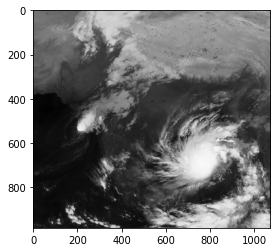

In [17]:
os.chdir("/content/drive/My Drive")
import cv2
import math
import rasterio
import matplotlib.pyplot as plt
import os
tifFilePath = "/content/drive/My Drive/tif/3DIMG_07NOV2019_0000_L1C_SGP.tif"
ColortoSaveAs = "/content/drive/My Drive/tif_converted/output.jpg"
sat_data = rasterio.open(tifFilePath)
b = sat_data.read(1)
fig = plt.imshow(b,cmap="gray")
plt.savefig(ColortoSaveAs)

Cloud Detection with Mask RCNN

[INFO] loading Mask R-CNN model...
Re-starting from epoch 8
[INFO] making predictions with Mask R-CNN...
Processing 1 images
image                    shape: (341, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}}
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}, '1': {'x': array([379, 380, 381, ..., 353, 359, 360]), 'y': array([222, 222, 222, ..., 293, 293, 293])}}
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}, '1': {'x': array([379, 380, 381, ..., 353, 359, 360]), 'y': array([222

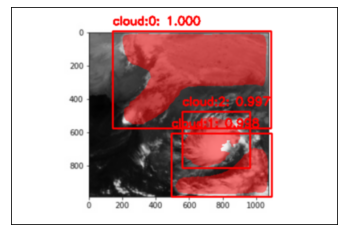

In [20]:
os.chdir('/content/drive/My Drive/Mask_RCNN')
import os
import sys
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from collections import defaultdict
CLASS_NAMES = open('/content/drive/My Drive/Mask_RCNN/test_mask_rcnn/labels.txt').read().strip().split("\n")

hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]
COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(COLORS)

class SimpleConfig(Config):
	NAME = "coco_inference"
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	NUM_CLASSES = len(CLASS_NAMES)

config = SimpleConfig()

print("[INFO] loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="inference", config=config,
	model_dir=os.getcwd())
model.load_weights('/content/drive/My Drive/Mask_RCNN/logs/cloud20200715T1252/mask_rcnn_cloud_0008.h5', by_name=True)


image = cv2.imread('/content/drive/My Drive/tif_converted/output.jpg')
# img = cv2.imread(args["image"],0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=512)

print("[INFO] making predictions with Mask R-CNN...")
r = model.detect([image], verbose=1)[0]

cloud_coordinates = {}
for i in range(0, r["rois"].shape[0]):
	classID = r["class_ids"][i]
	mask = r["masks"][:, :, i]
	color = COLORS[classID][::-1]
	coordinates = np.where(mask == True)
	x = coordinates[1]
	y = coordinates[0]
	cloud_coordinates[str(i)] = {'x':x,'y':y}
	image = visualize.apply_mask(image, mask, color, alpha=0.5)
	plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
	print(cloud_coordinates)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

count = 0
for i in range(0, len(r["scores"])):
	(startY, startX, endY, endX) = r["rois"][i]
	classID = r["class_ids"][i]
	label = CLASS_NAMES[classID]
	score = r["scores"][i]
	color = [int(c) for c in np.array(COLORS[classID]) * 255]
	cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
	text = "{}:{:}: {:.3f}".format(label,count, score)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.6, color,2)
	count = count + 1

com = defaultdict(list)
for i in range(r['rois'].shape[0]):
	l = (r['rois'][i].tolist())
	x = (l[1]+l[3])/2
	y = (l[0]+l[2])/2
	com[i].append(x)
	com[i].append(y)
# print(r['rois'])
# print(r['masks'])
# print(com)
with open("com.txt","a") as f:
	print(com,file=f)
plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
